# Машинное обучение, ФКН ВШЭ

# Семинар 9.

Пусть дана обучающая выборка $X = \{(x_i, y_i)\}_{i=1}^l$ и выбран функционал качества $Q(a, X) = \sum_{i=1}^l L(y_i, a(x_i)),$ который мы стремимся минимизировать. Градиентный бустинг строит композиции вида $a_N(x) = \sum_{n=0}^N \gamma_n b_n(x),$ где $b_n \in \mathcal{B}$ — базовые алгоритмы из некоторого семейства $\mathcal{B}$.

Композиция строится пошагово, на $n$-ом шаге к композиции добавляется алгоритм $b_n$ путём выполнения следующих действий:
 1. Вычисление сдвигов текущей композиции по выборке $X$: $$s_i^{(n)} = - \frac{\partial L}{\partial z} (y, z)\Bigg|_{z = a_{n-1}(x_i)}$$
 2. Обучение нового базового алгоритма на выборке $\{(x_i, s_i)\}_{i=1}^l$: $$b_n = \arg\min_{b \in \mathcal{B}} \sum_{i=1}^l (b_n(x_i) - s_i)^2$$
 3. Подбор коэффициента $\gamma_n$ при новом базовом алгоритме:
 $$\gamma_n = \arg \min_{\gamma} \sum_{i=1}^l L(y_i, a_{n-1}(x_i) + \gamma b_n(x_i))$$
 
Как обсуждалось ранее, при использовании градиентного бустинга можно понизить смещение моделей, но при этом разброс итоговой композиции останется таким же, как у отдельного базового алгоритма, или увеличится. Поэтому в качестве базовых алгоритмов удобно брать решающие деревья малой глубины, поскольку они обладают большим смещением и малым разбросом.


## Градиентный бустинг и бэггинг

Сравним, как ведут себя бустинг и бэггинг с ростом числа базовых алгоритмов.

Напомним, что для построения композиции при помощи бэггинга из $X$ случайно и независимо выбираются подвыборки $\tilde{X}_n, n = 1, \dots, N.$ После этого на каждой из этих выборок обучается алгоритм из параметрического множества $\mathcal{B},$ в результате чего получаем алгоритмы $b_n(x), n = 1, \dots, N.$ Прогноз итоговой композиции строится следующим образом: 

$$a(x) = \frac{1}{N} \sum_{n=1}^N b_n(x)$$ (в случае регрессии),

$$a(x) = \arg \max_{k = 1, \dots, K} \sum_{n=1}^N [b_n(x) = k]$$ (в случае классификации на K классов).

В случае бэггинга все базовые алгоритмы настраиваются на различные выборки из одного и того же распределения на $\mathbb{X} \times \mathbb{Y}$. При этом некоторые из них могут оказаться переобученными, однако усреднение позволяет ослабить этот эффект (объясняется тем, что для некоррелированных алгоритмов разброс композиции оказывается в $N$ раз меньше разброса отдельных алгоритмов, т.е. много деревьев с меньшей вероятностью настроятся на некоторый нетипичный объект по сравнению с одним деревом). Если $N$ достаточно велико, то последующие добавления новых алгоритмов уже не позволят улучшить качество модели.

В случае же бустинга каждый алгоритм настраивается на ошибки всех предыдущих, это позволяет на каждом шаге настраиваться на исходное распределение все точнее и точнее. Однако при достаточно большом $N$ это является источником переобучения, поскольку последующие добавления новых алгоритмов будут продолжать настраиваться на обучающую выборку, уменьшая ошибку на ней, при этом уменьшая обобщающую способность итоговой композиции.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

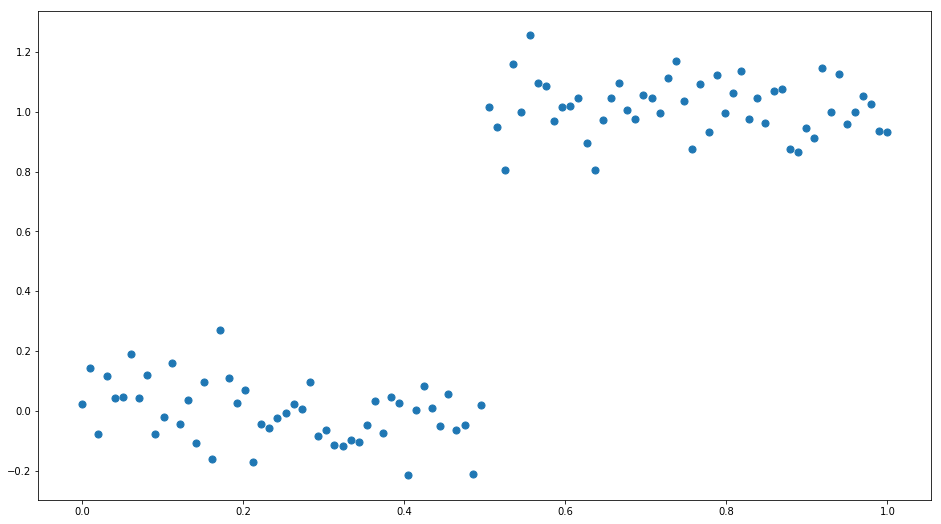

In [7]:
X_train = np.linspace(0, 1, 100)
X_test = np.linspace(0, 1, 1000)

@np.vectorize
def target(x):
    return x > 0.5

Y_train = target(X_train) + np.random.randn(*X_train.shape) * 0.1

plt.figure(figsize = (16, 9))
plt.scatter(X_train, Y_train, s=50)

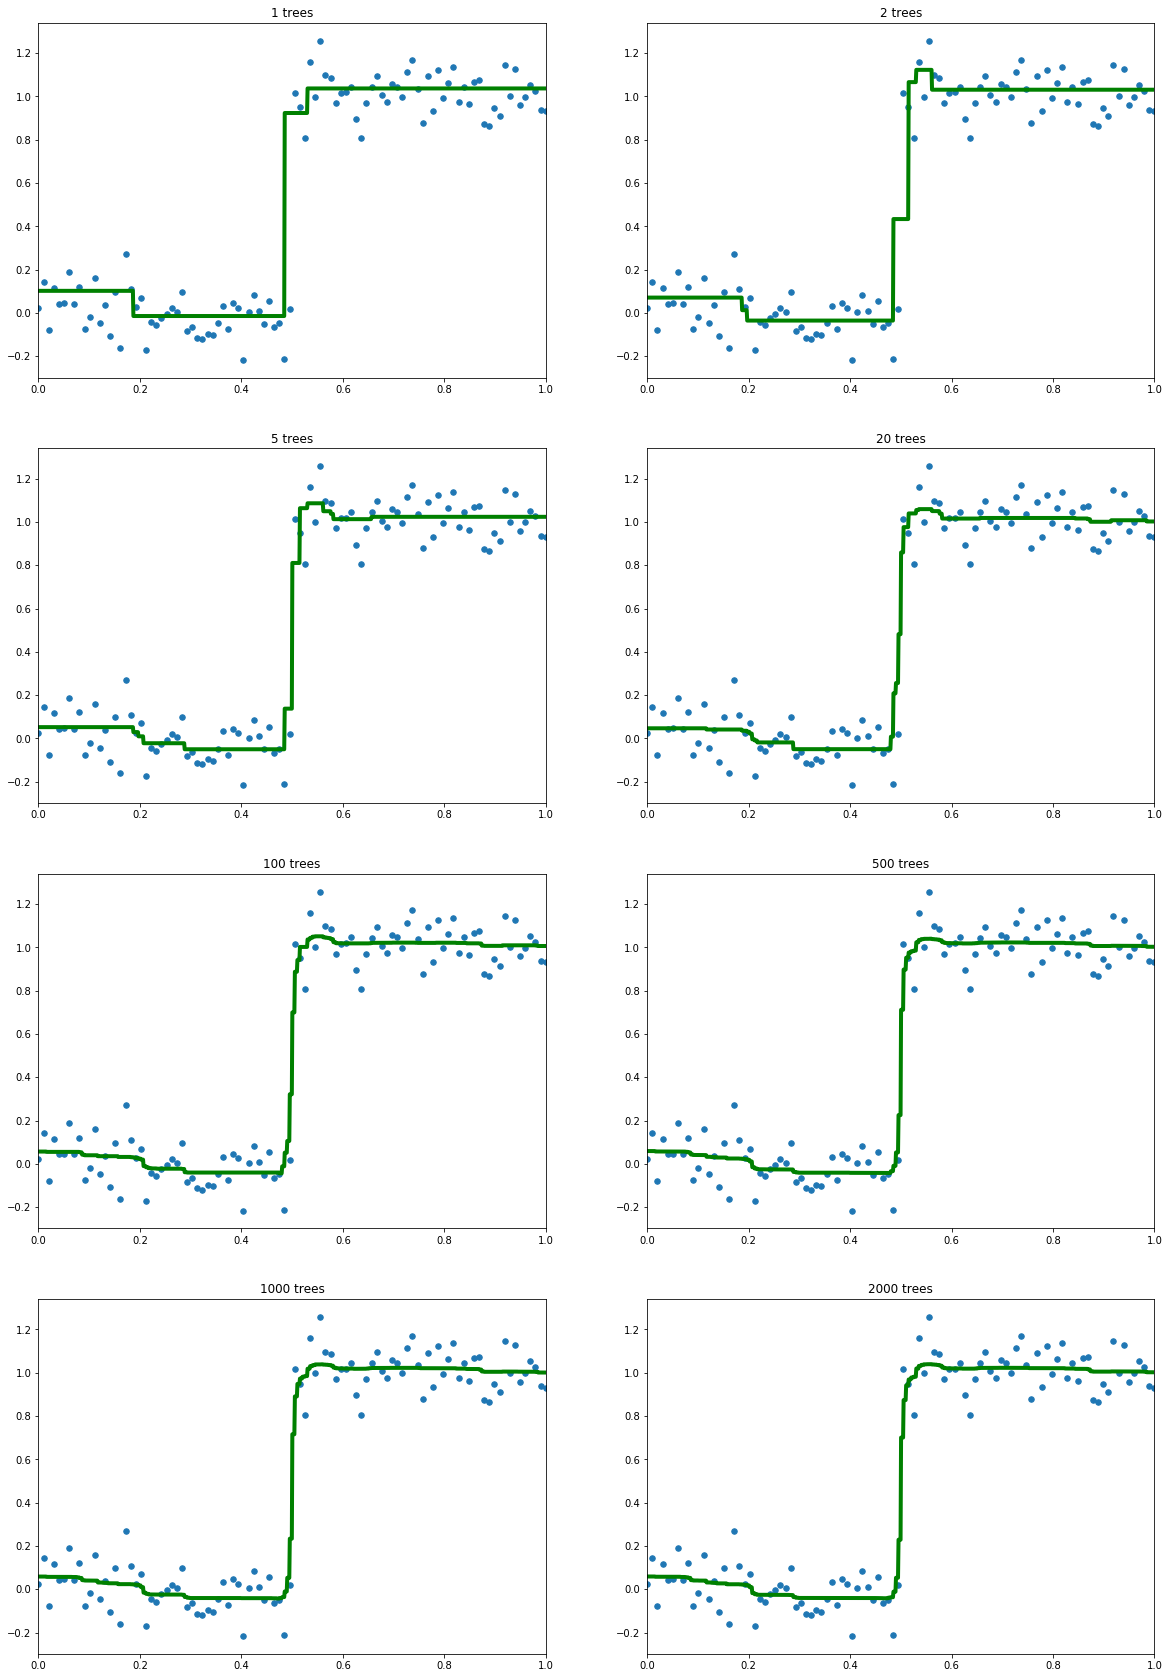

In [8]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor

reg = BaggingRegressor(DecisionTreeRegressor(max_depth=2), warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Можно заметить, что с некоторого момента итоговая функция перестает меняться с ростом количества деревьев.

Теперь проделаем то же самое для градинентного бустинга.

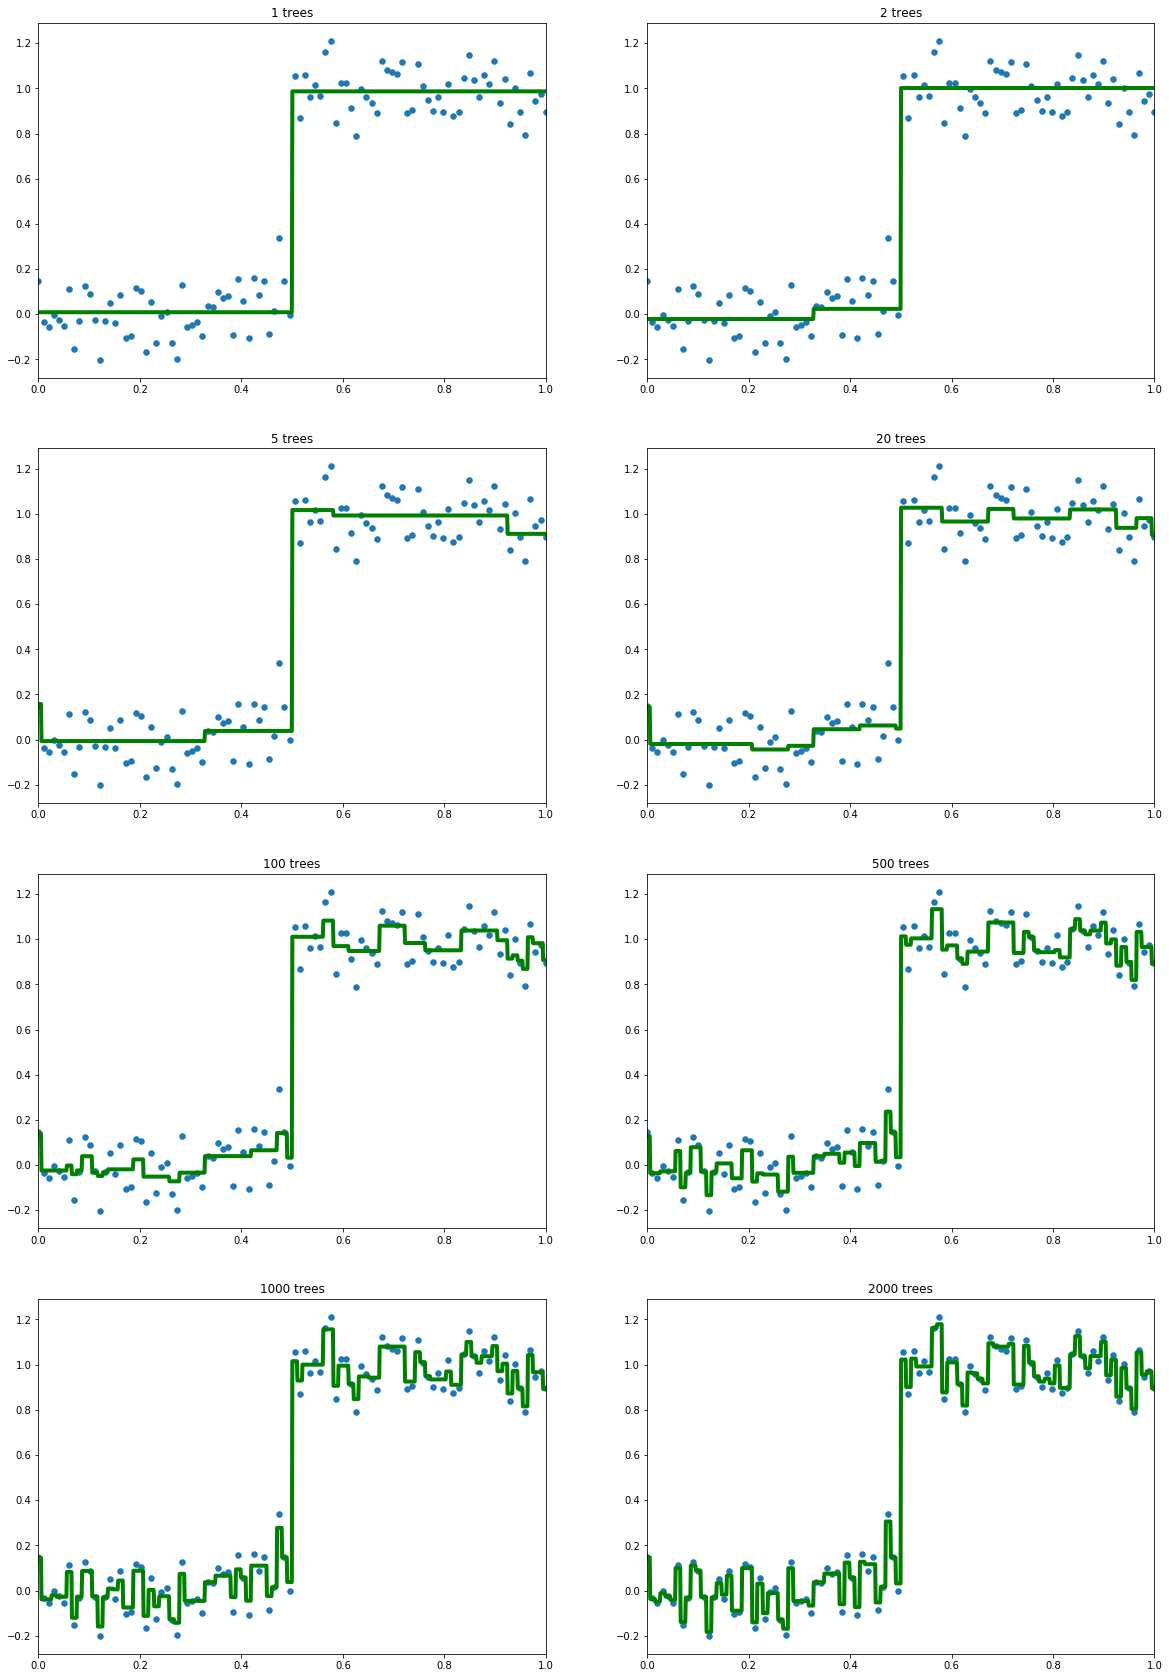

In [4]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Градиентный бустинг довольно быстро построил истинную зависимость, после чего начал настраиваться уже на конкретные объекты обучающей выборки, из-за чего сильно переобучился.


Бороться с этой проблемой можно с помощью выбора очень простого базового алгоритма или
же искусственным снижением веса новых алгоритмов при помощи шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_N b_n(x).$$

Такая поправка замедляет обучение по сравнению с бэггингом, но зато позволяет получить менее переобученный алгоритм. Тем не менее, важно понимать, что переобучение всё равно будет иметь место при обучении сколь угодно большого количества базовых алгоритмов для фиксированного $\eta$.

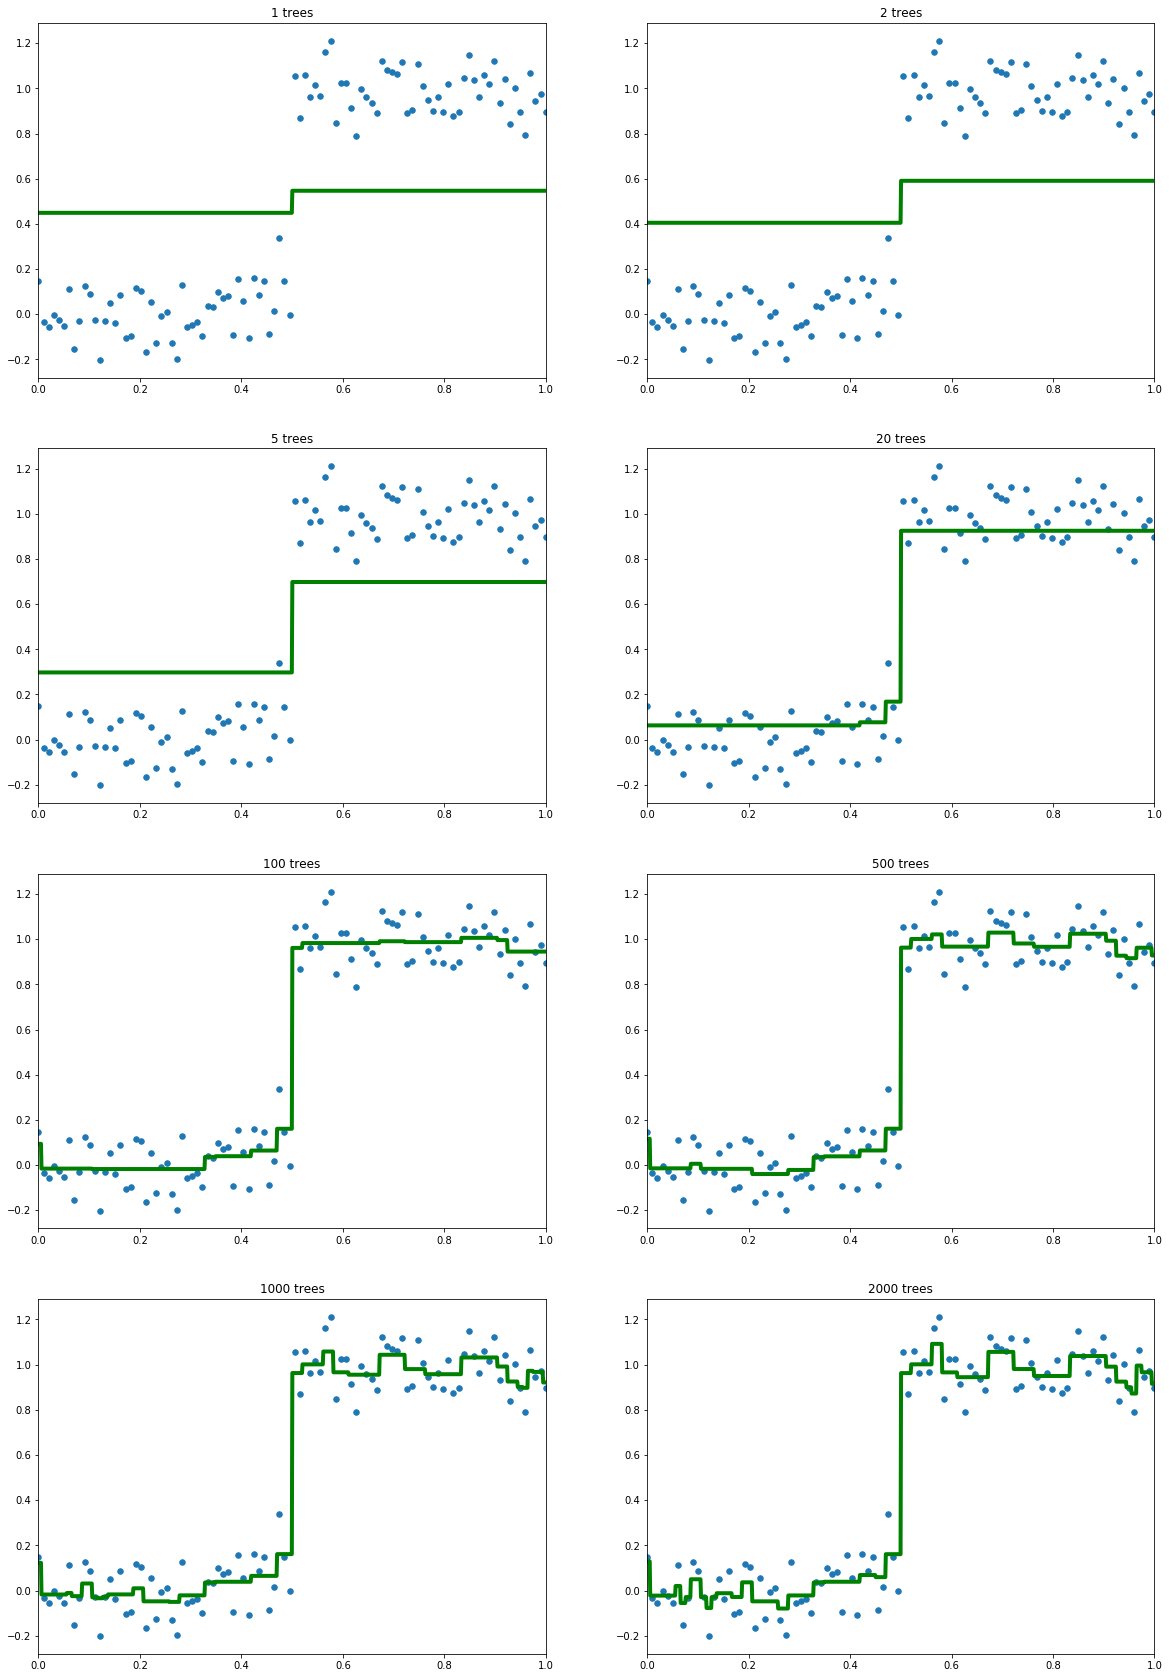

In [5]:
reg = GradientBoostingRegressor(max_depth=1, learning_rate=0.1, warm_start=True)
plt.figure(figsize=(20, 30))
sizes = [1, 2, 5, 20, 100, 500, 1000, 2000]
for i, s in enumerate(sizes):
    reg.n_estimators = s
    reg.fit(X_train.reshape(-1, 1), Y_train)
    plt.subplot(4, 2, i+1)
    plt.xlim([0, 1])
    plt.scatter(X_train, Y_train, s=30)
    plt.plot(X_test, reg.predict(X_test.reshape(-1, 1)), c='green', linewidth=4)
    plt.title('{} trees'.format(s))

Теперь проверим описанный выше эффект на реальных данных.

In [6]:
from sklearn import datasets
from sklearn.model_selection import train_test_split

ds = datasets.load_diabetes()
X = ds.data
Y = ds.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.5)

MAX_ESTIMATORS = 250

gbclf = GradientBoostingRegressor(warm_start=True)
err_train_gb = []
err_test_gb = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_gb.append(1 - gbclf.score(X_train, Y_train))
    err_test_gb.append(1 - gbclf.score(X_test, Y_test))

gbclf = BaggingRegressor(warm_start=True)
err_train_bag = []
err_test_bag = []
for i in range(1, MAX_ESTIMATORS+1):
    gbclf.n_estimators = i
    gbclf.fit(X_train, Y_train)
    err_train_bag.append(1 - gbclf.score(X_train, Y_train))
    err_test_bag.append(1 - gbclf.score(X_test, Y_test))

/Users/nikishin_evg/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Text(0.5,1,'Test')

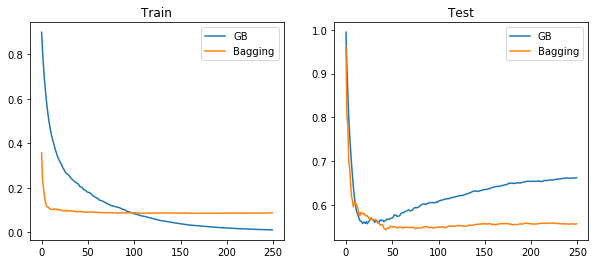

In [7]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(err_train_gb, label='GB')
plt.plot(err_train_bag, label='Bagging')
plt.legend()
plt.title('Train')
plt.subplot(1, 2, 2)
plt.plot(err_test_gb, label='GB')
plt.plot(err_test_bag, label='Bagging')
plt.legend()
plt.title('Test')

## Градиентный бустинг и случайные леса

Сравним поведение двух методов построения композиции алгоримтов над деревьями на примере задачи [Kaggle: Predicting a Biological Response](https://www.kaggle.com/c/bioresponse):

In [8]:
import pandas as pd
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


data = pd.read_csv('train.csv')
X = data.iloc[:, 1:].values
y = data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=241)

In [9]:
%%time
gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=0.2, verbose=True).fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2613           14.22s
         2           1.1715           14.29s
         3           1.1009           14.28s
         4           1.0529           16.82s
         5           1.0130           17.46s
         6           0.9740           17.98s
         7           0.9475           18.17s
         8           0.9197           17.65s
         9           0.8979           16.90s
        10           0.8730           16.49s
        20           0.7207           14.14s
        30           0.6055           15.24s
        40           0.5244           14.19s
        50           0.4501           13.63s
        60           0.3908           13.07s
        70           0.3372           12.31s
        80           0.3009           11.36s
        90           0.2603           10.65s
       100           0.2327            9.97s
       200           0.0835            3.05s
CPU times: user 14.3 s, sys: 207 ms, total: 14.5 s
Wal

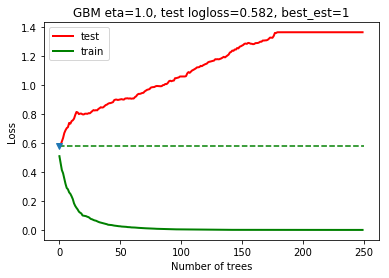

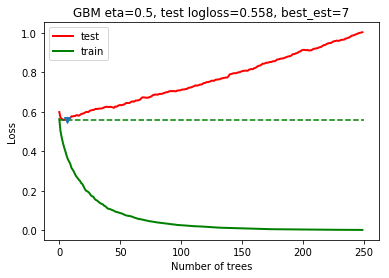

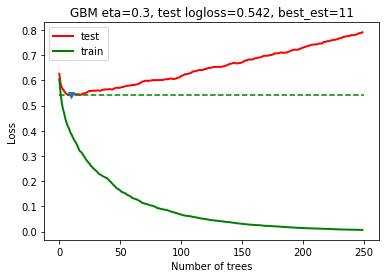

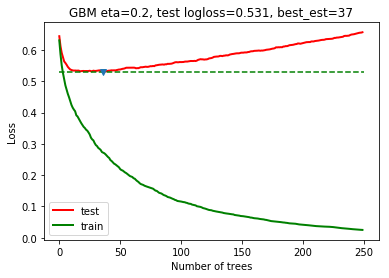

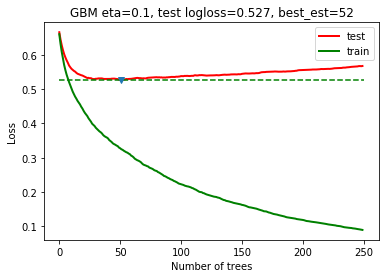

In [10]:
import numpy as np
from sklearn.metrics import log_loss

for learning_rate in [1, 0.5, 0.3, 0.2, 0.1]:

    gbm = GradientBoostingClassifier(n_estimators=250, learning_rate=learning_rate, random_state=241).fit(X_train, y_train)
    
    l = log_loss

    test_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_test)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        test_deviance[i] = l(y_test, y_pred)

    train_deviance = np.zeros((gbm.n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(gbm.staged_decision_function(X_train)):
        y_pred = 1.0 / (1.0 + np.exp(-y_pred))
        train_deviance[i] = l(y_train, y_pred)

    plt.figure()
    plt.plot(test_deviance, 'r', linewidth=2)
    plt.plot(train_deviance, 'g', linewidth=2)
    plt.legend(['test', 'train'])
    plt.plot([0, train_deviance.shape[0]], [test_deviance.min(), test_deviance.min()], 'g--')
    plt.plot([test_deviance.argmin()], [test_deviance.min()], 'v')
    plt.title('GBM eta=%.1f, test logloss=%.3f, best_est=%d' % (learning_rate, test_deviance.min(), test_deviance.argmin()+1))
    plt.xlabel('Number of trees')
    plt.ylabel('Loss')

Итого, лучшая композиция построена при $\eta = 0.1$, включает 52 базовых алгоритма и достигает значения 0.526 на контрольной выборке. При этом случайный лес с таким же количеством базовых алгоритмов уступает градиентному бустингу:

In [11]:
rf = RandomForestClassifier(n_estimators=52, random_state=241).fit(X_train, y_train)
print ('Train RF log-loss =', log_loss(y_train, rf.predict_proba(X_train)))
print ('Test RF log-loss = ', log_loss(y_test, rf.predict_proba(X_test)))

Train RF log-loss = 0.156601783371
Test RF log-loss =  0.538159117307


Заметим также, что при всём этом случайный лес, в отличие от градиентного бустинга, использует глубокие деревья, требующие вычислительных мощностей для их обучения.

Для достижения такого же качества случайному лесу требуется гораздо большее число базовых алгоритмов:

In [12]:
for n_estimators in range(10, 101, 10):
    rf = RandomForestClassifier(n_estimators=n_estimators, n_jobs=4).fit(X_train, y_train)
    print (n_estimators, 'trees: train log-loss =', log_loss(y_train, rf.predict_proba(X_train)), 'test log-loss =', log_loss(y_test, rf.predict_proba(X_test)))

10 trees: train log-loss = 0.16335405833 test log-loss = 0.809253210278
20 trees: train log-loss = 0.157599413714 test log-loss = 0.567217946726
30 trees: train log-loss = 0.161755120979 test log-loss = 0.552282097114
40 trees: train log-loss = 0.158872281525 test log-loss = 0.540038838277
50 trees: train log-loss = 0.157707182355 test log-loss = 0.536467520924
60 trees: train log-loss = 0.156669570383 test log-loss = 0.529009695106
70 trees: train log-loss = 0.155922921087 test log-loss = 0.529452517216
80 trees: train log-loss = 0.153484206689 test log-loss = 0.52171725922
90 trees: train log-loss = 0.153927433057 test log-loss = 0.520701973688
100 trees: train log-loss = 0.154696435107 test log-loss = 0.527501535148


## Свойства градиентного бустинга над решающими деревьями

**Задача 1.** Пусть решается задача регрессии на одномерной выборке $X = \{ (x_i, y_i)\}_{i=1}^l,$ при этом истинная зависимость целевой переменной является линейной: $y(x) = ax + \varepsilon, \, \varepsilon \sim p(\varepsilon) = \mathcal{N} (0, \sigma^2).$ Допустим, не зная этого, вы обучили на выборке линейную регрессию и решающее дерево с функционалом MSE, и вам известно, что модели не переобучились. После этого вы получили новые данные и построили на них прогнозы обеих моделей, и оказалось, что для решающего дерева значение функционала ошибки на новых данных оказалось радикально выше, чем для линейной регрессии. Чем это может быть вызвано?

**Решение.**
Поскольку истинная зависимость в данных является линейной, логично предположить, что линейная модель покажет лучшие результаты на подобной выборке. Опишем формально ситуацию, в которой у решающего дерева могут возникнуть серьезные проблемы с восстановлением истинной зависимости.

Допустим, обучающая выборка была получена из отрезка $[0; 10],$ обучим соответствующие модели и построим прогнозы для этого отрезка:

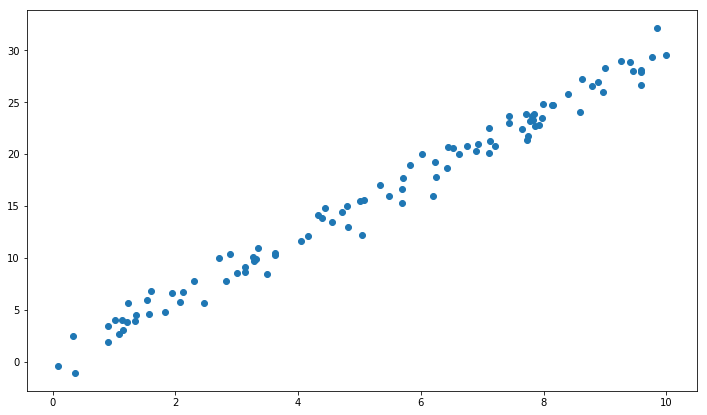

In [13]:
from numpy.random import rand, randn

set_size = 100
lin_coef = 3
sigma = 1

X_train = (rand(set_size) * 10).reshape(-1, 1)
Y_train = X_train * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)

In [14]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, Y_train)
tree = DecisionTreeRegressor()
tree.fit(X_train, Y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

LR train MSE =  1.15916484384
DT train MSE =  0.0


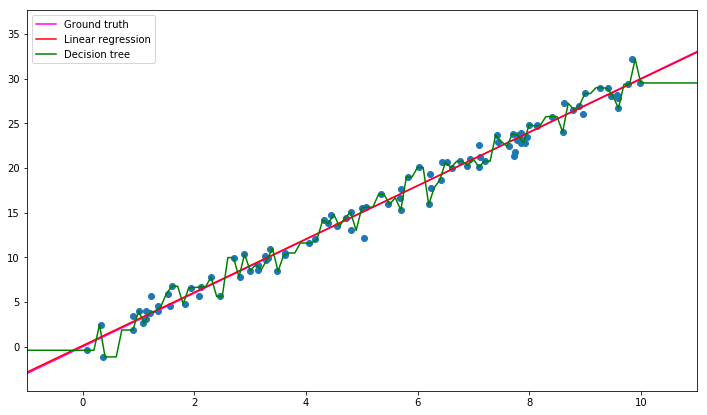

In [15]:
from numpy.random import rand, randn

grid = np.arange(-1, 12, 0.1).reshape(-1, 1)

plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train)
plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 11])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR train MSE = ', mean_squared_error(Y_train, lr.predict(X_train)))
print ('DT train MSE = ', mean_squared_error(Y_train, tree.predict(X_train)))

Предположим, что новые данные были получены из другой области пространства ответов, например, из отрезка $[20; 30].$ В этом случае предсказания линейной регрессии окажутся гораздо ближе к правде, что отразится и на значении функционала ошибки:

LR test MSE =  1.21262364943
DT test MSE =  2017.70838827


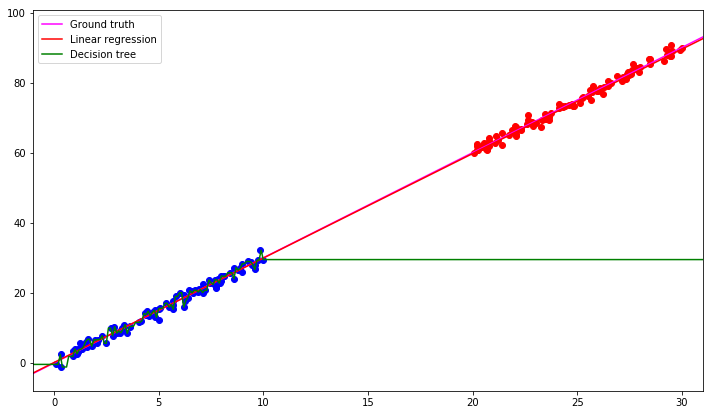

In [16]:
from numpy.random import rand, randn

grid = np.arange(-1, 32, 0.1).reshape(-1, 1)

X_test = (20 + rand(set_size) * 10).reshape(-1, 1)
Y_test = X_test * 3 + sigma * randn(set_size).reshape(-1, 1)
plt.figure(figsize=(12, 7))
plt.scatter(X_train, Y_train, c='blue')
plt.scatter(X_test, Y_test, c='red')

plt.plot(grid, lin_coef * grid, 'magenta')
plt.plot(grid, lr.predict(grid), 'red',)
plt.plot(grid, tree.predict(grid), 'green')
plt.xlim([-1, 31])
plt.legend(['Ground truth', 'Linear regression', 'Decision tree'], loc=0)
print ('LR test MSE = ', mean_squared_error(Y_test, lr.predict(X_test)))
print ('DT test MSE = ', mean_squared_error(Y_test, tree.predict(X_test)))

**Вывод**: решающие деревья (а потому и композиции над ними, в т.ч. градиентный бустинг) непригодны для экстраполяции функций.

В качестве решения этой проблемы в некоторых случаях можно использовать [нормализацию](http://scikit-learn.org/stable/modules/preprocessing.html#preprocessing-normalization).

**Задача 2.** Пусть решается задача регрессии для двумерной выборки $X = \{ (x_i, y_i) \}_{i=1}^l,$ при этом истинная зависимость целевой переменной $y(x) = y((x_1, x_2)) = sgn ((x_1 - 40)x_2).$ Предположим, вы обучили на выборке $X$ решающие деревья глубины 1, 2 и 3. Как соотносятся значения функционала $MSE$ для каждой из этих моделей? Почему? Какие зависимости позволяют улавливать глубокие деревья по сравнению с неглубокими?

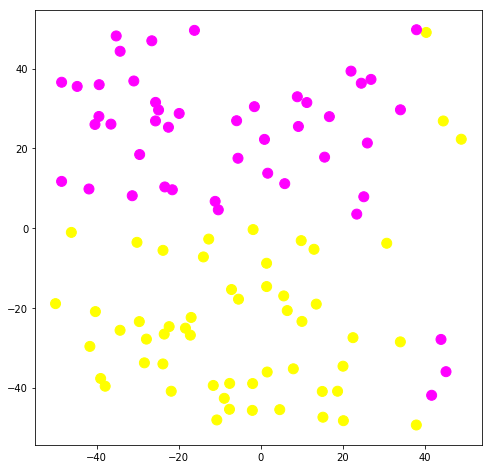

In [17]:
X = -50 + 100 * np.random.rand(100, 2)
Y = np.sign((X[:, 0] - 40) * X[:, 1])
plt.figure(figsize=(8, 8))
plt.scatter(X[:, 0], X[:, 1], c=Y, s=100, cmap='spring')

DT MSE (max_depth = 1) =  0.225507246377
DT MSE (max_depth = 2) =  0.0
DT MSE (max_depth = 3) =  0.0


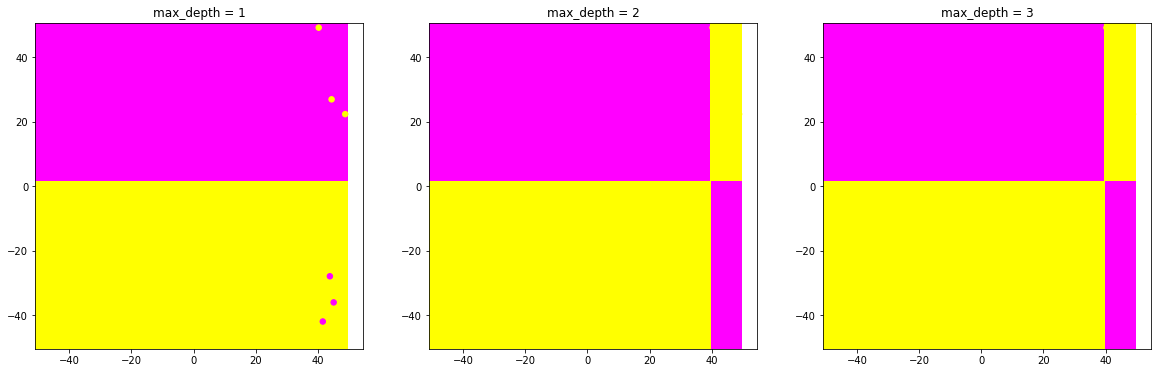

In [18]:
def get_grid(data):
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    return np.meshgrid(np.arange(x_min, x_max, 0.5),
                         np.arange(y_min, y_max, 0.5))
plt.figure(figsize=(20, 6))
for i in range(3):
    clf = DecisionTreeRegressor(random_state=42, max_depth = i + 1)

    clf.fit(X, Y)
    xx, yy = get_grid(X)
    predicted = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.subplot2grid((1, 3), (0, i))
    plt.pcolormesh(xx, yy, predicted, cmap='spring')
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=30, cmap='spring')
    plt.title('max_depth = ' + str(i + 1))
    print('DT MSE (max_depth = ' + str(i+1) + ') = ', mean_squared_error(Y.reshape(-1, 1), clf.predict(X)))

Можно видеть, что с незначительным ростом глубины дерева ошибка на данных стремительно падает. Это связано с тем, что истинная зависимость целевой переменной учитывает взаимодействия признаков, а потому дерево глубины 1 в любом случае не может восстановить подобную зависимость, поскольку учитывается лишь один из признаков; дерево глубины 2 позволяет учесть взаимодействие пар признаков и т.д.

**Вывод**: если вам известно, что в задаче необходимо учитывать взаимодействие $N$ признаков, корректным решением будет ограничивать глубину деревьев в градиентном бустинге числом, большим $N$. Кроме того, если вам из некоторых экспертных знаний известно, что на целевую переменную оказывает влияние конкретное взаимодействие различных признаков, следует добавить его явно в качестве признака, поскольку это может позволить повысить качество.

**Задача 3.** Пусть дана некоторая выборка $X = \{ (x_i, y_i)\}_{i=1}^l.$ Как изменится решающее дерево, обученное на этой выборке, при масштабировании признаков?

**Решение.** Рассмотрим некоторую вершину $m$ и множество $R_m$ объектов, попавших в неё. Заметим, что значение целевой переменной при масштабировании не изменится, а потом значение критерия информативности для каждого из возможных разбиений останется тем же самым (изменятся лишь значения порогов для каждого из признаков). В связи с этим в вершине $m$ в качестве оптимального будет выбрано то же разбиение, что и раньше. Поскольку это верно для любой вершины, построенное решающее дерево не изменится.

Данные рассуждения также верны для любого монотонного преобразования признаков.

### Размер шага в градиентном бустинге

Напомним, что в качестве меры для борьбы с переобучением в градиентном бустинге используют размер шага $\eta$:
$$a_N(x) = \sum_{n=0}^N \eta \gamma_n b_n(x).$$

Исследуем зависимость скорости сходимости градиентного бустинга в зависимости от размера шага и богатства семейства базовых алгоритмов $\mathcal{B}$. На каждом шаге мы выбираем новый базовый алгоритм из семейства, обучая его на векторе сдвигов. Тем не менее, не всегда получается найти алгоритм, идеально приближающие посчитанный вектор сдвигов, поэтому иногда добавление нового базового алгоритма может "увести" нас в сторону.

Рассмотрим обычный градиентный спуск и смоделируем описанную ситуацию, используя не честно посчитанный антиградиент, а его зашумленный вариант, и исследуем, за какое количество шагов (сколько базовых алгоритмов потребуется бустингу) мы сможем оказаться в окрестности оптимума в зависимости от длины шага:

In [19]:
def fun(x, y):
    return x**2 + 2 * y ** 2
   
def grad(x, y):
    return np.array([2 * x, 4 * y])

def make_data():
    x = np.arange (-100, 100, 0.1)
    y = np.arange (-100, 100, 0.1)
    xgrid, ygrid = np.meshgrid(x, y)
    zgrid = fun(xgrid, ygrid)
#    zgrid = np.sin (xgrid) * np.sin (ygrid) / (xgrid * ygrid)
    return xgrid, ygrid, zgrid


def gradient_descent(numIterations, eta, noise):
    ans = np.array([-70, 80])
    x_points = [ans[0]]
    y_points = [ans[1]]
    for iter in range(0, numIterations):
        ans = ans - eta * (grad(ans[0], ans[1]) + noise * np.random.randn(2))
        x_points.append(ans[0])
        y_points.append(ans[1])
    return (x_points, y_points)

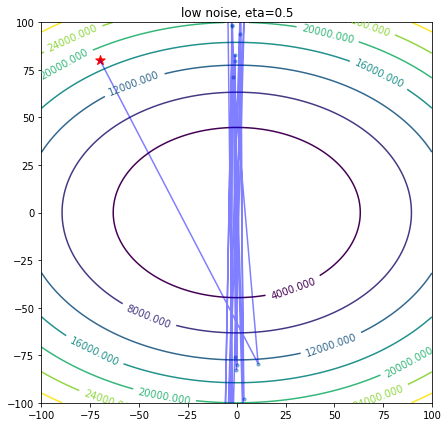

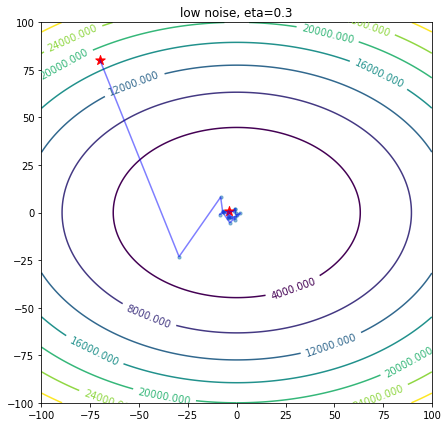

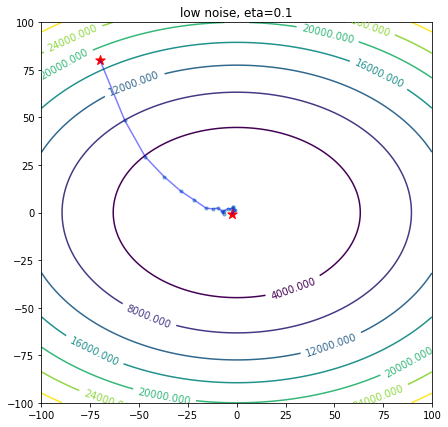

In [20]:
import numpy as np
from sklearn.metrics import log_loss
X, Y, Z = make_data()

for learning_rate in [0.5, 0.3, 0.1]:
    x_points, y_points = gradient_descent(20, learning_rate, 10)
    plt.figure(figsize = (7, 7))
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x_points, y_points, linestyle = '-', color = 'blue', alpha = 0.5)
    plt.scatter(x_points[1:-1], y_points[1:-1], marker = '.', s=40, alpha = 0.5)
    plt.scatter([x_points[0], x_points[-1]], [y_points[0], y_points[-1]], 
                marker = '*', s=100, color = 'red')
    
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.title('low noise, eta=%.1f' % learning_rate)

Если семейство алгоритмов $\mathcal{B}$ более бедное, то направление движение на каждом шаге будет сильнее отличаться от антиградиента:

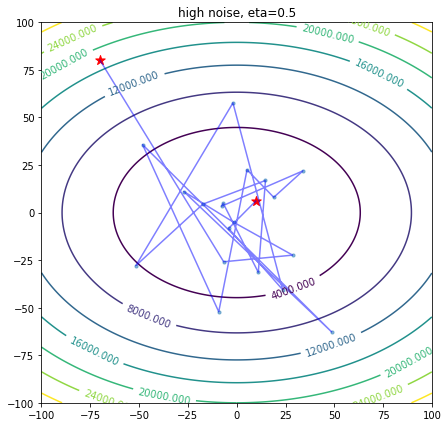

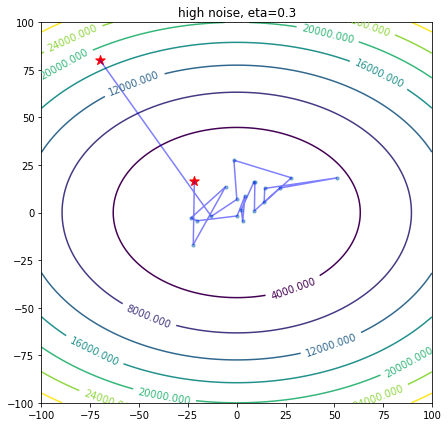

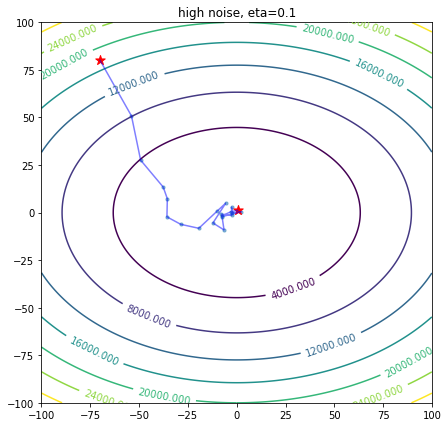

In [21]:
import numpy as np
from sklearn.metrics import log_loss
X, Y, Z = make_data()

for learning_rate in [0.5, 0.3, 0.1]:
    x_points, y_points = gradient_descent(20, learning_rate, 50)
    plt.figure(figsize = (7, 7))
    CS = plt.contour(X, Y, Z)
    plt.clabel(CS, inline=1, fontsize=10)
    plt.plot(x_points, y_points, linestyle = '-', color = 'blue', alpha = 0.5)
    plt.scatter(x_points[1:-1], y_points[1:-1], marker = '.', s=40, alpha = 0.5)
    plt.scatter([x_points[0], x_points[-1]], [y_points[0], y_points[-1]], 
                marker = '*', s=100, color = 'red')
    
    plt.xlim([-100, 100])
    plt.ylim([-100, 100])
    plt.title('high noise, eta=%.1f' % learning_rate)

Можно видеть, что с уменьшением размера шага градиентному бустингу требуется больше базовых алгоритмов для достижения приемлемого качества композиции, однако при этом сходимость такого процесса надежнее.

## Современные библиотеки

Ранее мы использовали наивную версию градиентного бустинга из scikit-learn, [придуманную](https://projecteuclid.org/download/pdf_1/euclid.aos/1013203451) в 1999 году Фридманом. С тех пор было предложено много реализаций, которые оказываются лучше на практике. На сегодняшний день популярны три библиотеки, реализующие градиентный бустинг:
* XGBoost. После выхода быстро набрала популярность и оставалась стандартом до конца 2016 года. Об особенностях данной библиотеки рассказывалось на лекции.
* LightGBM. Отличительной чертой является быстрота построения композиции. Например, используется следующий трюк для ускорения обучения: при построении вершины дерева вместо перебора по всем значениям признака производится перебор значений гистограммы этого признака. Таким образом, вместо $O(\ell)$ требуется $O$(#bins). Кроме того, в отличие от других библиотек, которые строят дерево по уровням, LightGBM использует стратегию best-first, т.е. на каждом шаге строит вершину, дающую наибольшее уменьшение функционала. Поэтому ограничение на num_leaves получается более осмысленным.
* CatBoost. Библиотека от компании Яндекс. Позволяет автоматически обрабатывать категориальные признаки. Кроме того, алгоритм является менее чувствительным к выбору конкретных гиперпараметров. За счёт этого уменьшается время, которое тратит человек на подбор оптимальных гиперпараметров.

### Основные параметры
* objective – функционал, на который будет настраиваться композиция
* eta / learning_rate – темп (скорость) обучения
* num_iterations / n_estimators  – число итераций бустинга

#### Параметры, отвечающие за сложность деревьев
* max_depth – максимальная глубина 
* max_leaves / num_leaves – максимальное число вершин в дереве
* gamma / min_gain_to_split – порог на уменьшение функции ошибки при расщеплении в дереве
* min_data_in_leaf – минимальное число объектов в листе
* min_sum_hessian_in_leaf – минимальная сумма весов объектов в листе, минимальное число объектов, при котором делается расщепление 
* lambda – коэффициент регуляризации (L2)
* subsample / bagging_fraction – какую часть объектов обучения использовать для построения одного дерева 
* colsample_bytree / feature_fraction – какую часть признаков использовать для построения одного дерева 

Подбор всех этих параметров — настоящее искусство. Но начать их настройку можно с самых главных параметров: learning_rate и n_estimators. Обычно один из них фиксируют, а оставшийся из этих двух параметров подбирают (например, фиксируют n_estimators=1000 и подбирают learning_rate). Следующим по важности является max_depth. В силу того, что мы заинтересованы в неглубоких деревьях, обычно его перебирают из диапазона [3; 7].




## XGBoost

/Users/nikishin_evg/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


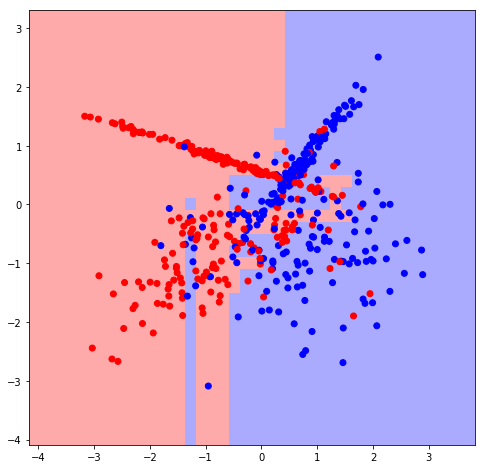

In [22]:
from sklearn.datasets import make_classification
from matplotlib.colors import ListedColormap
import xgboost as xgb

cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

def plot_surface(X, y, clf):
    h = 0.2
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8, 8))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

X, y = make_classification(n_samples=500, n_features=2, n_informative=2,
                           n_redundant=0, n_repeated=0,
                           n_classes=2, n_clusters_per_class=2,
                           flip_y=0.05, class_sep=0.8, random_state=241)
clf = xgb.XGBClassifier()
clf.fit(X, y)
plot_surface(X, y, clf)

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=241)

clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)

print (roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

0.900782361309


In [24]:
?xgb.XGBClassifier

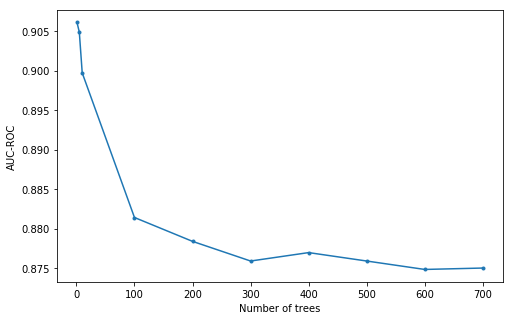

In [25]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = xgb.XGBClassifier(n_estimators=n, max_depth=6, learning_rate=0.5)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()

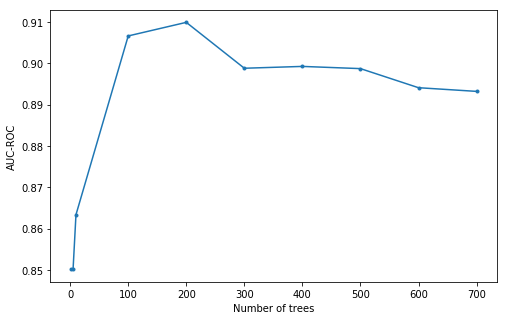

In [26]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = xgb.XGBClassifier(n_estimators=n, max_depth=2, learning_rate=0.03)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()

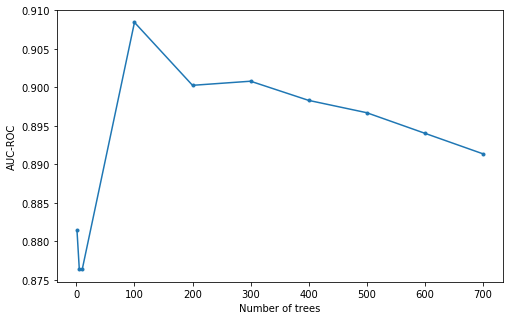

In [27]:
n_trees = [1, 5, 10, 100, 200, 300, 400, 500, 600, 700]
quals = []
for n in n_trees:
    clf = xgb.XGBClassifier(n_estimators=n, max_depth=6,
                            learning_rate=0.03, reg_lambda=0)
    clf.fit(X_train, y_train)
    q = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    quals.append(q)
    
plt.figure(figsize=(8, 5))
plt.plot(n_trees, quals, marker='.')
plt.xlabel('Number of trees')
plt.ylabel('AUC-ROC')
plt.show()

Напоследок можно посмотреть [визуализацию](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html) градиентного бустинга для решающих деревьев различной глубины для функций различного вида.